In [83]:
import numpy as np
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pickle
from scipy.special import sici

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
})


In [84]:
with open('/home/fverdian/class/soundspeed-scripts/1loop/Pk-lin-int.pkl', 'rb') as f:
    Plin_int = pickle.load(f)
fact=(2*np.pi)**3

def F3(k,q,mu):
    k2=k*k;q2=q*q;mu2=mu*mu
    kMq2 = k2 + q2 - 2*k*q*mu 
    kPq2 = k2 + q2 + 2*k*q*mu 

    res1 = 1/kMq2*(5/126*k2-11/108*k*q*mu+7/108*q2*mu2-1/54*k2*k2*mu2/q2+4/189*k2*k*mu2*mu/q-23/756*k2*k*mu/q+25/252*k2*mu2-2/27*k*q*mu2*mu)
    res2 = 1/kPq2*(5/126*k2+11/108*k*q*mu-7/108*q2*mu2-4/27*k2*k2*mu2/q2-53/189*k2*k*mu2*mu/q+23/756*k2*k*mu/q-121/756*k2*mu2-5/27*k*q*mu2*mu)
    return res1+res2

def F2(k,q,mu):
    k2=k*k;q2=q*q;mu2=mu*mu
    kMq2 = k2 + q2 - 2*k*q*mu 
    return (k2*(7*k*q*mu+3*q2)-10*k2*q2*mu2)/(14*q2*kMq2)

def alpha(k1,k2,cT):
    return 1+cT*k2/k1

def alphas(k1,k2,cT):
    return 1+0.5*cT*(k2/k1+k1/k2)

def beta(k1,k2,cT):
    t1=k1*k1+k2*k2+2*k1*k2*cT
    t2=k1*k2*cT
    t3=2.*k1*k1*k2*k2
    return t1*t2/t3

def F2G2_EdS(k1,k2,cT):
    return [(5./7.)*alphas(k1,k2,cT)+(2./7.)*beta(k1,k2,cT),(3./7)*alphas(k1,k2,cT)+(4./7)*beta(k1,k2,cT),0.,0.]

In [125]:
fx=0.1
fullt=np.linspace(-3,2, 1000)
teval=0
idx_eta=np.abs(fullt - (0.)).argmin()
kref=0.1
supprshift=5

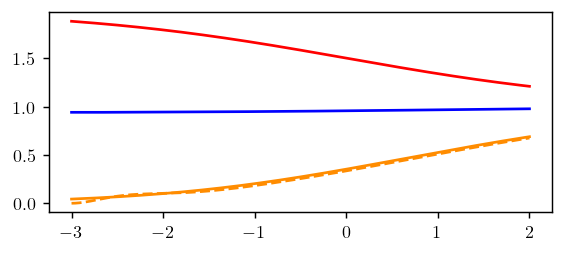

In [126]:
# this is solved fot k=0.1 (for which tildeeta = eta) and then I shift it using the smmetry
def lin_system(w,t):
    dc,Tc,dx,Tx = w
    ddcdt = Tc
    dTcdt = -0.5*Tc+1.5*(1-fx)*dc+1.5*fx*dx
    ddxdt = Tx
    dTxdt = -0.5*Tx+1.5*(1-fx)*dc+1.5*(fx-(1)*np.exp(-t))*dx -np.exp(-t-supprshift)*ddxdt
    return [ddcdt, dTcdt,ddxdt, dTxdt]
# Initial conditions
w0 = [1,1-3/5*fx,0.,0.]
# Solve the differential equation
tlin=np.linspace(fullt[0],fullt[-1],1000)

linsol = odeint(lin_system, w0, tlin)


g_c_int=interp1d(tlin,linsol[:,1]/linsol[:, 0],bounds_error=False,  fill_value=(5/4*np.sqrt(1-24/25*fx)-1/4,1))
g_x_int=interp1d(tlin,linsol[:, 3]/linsol[:, 0],bounds_error=False, fill_value=(0.,1.))
g_int=interp1d(tlin,linsol[:, 2]/linsol[:, 0],bounds_error=False,fill_value=(0.,1.))
# hOg_int=interp1d(tlin,linsol[:, 3]/linsol[:, 2],bounds_error=False,fill_value=(2.,1.))

def g_an(t):
    return  1 + 6 * np.exp(-t) * np.cos(np.sqrt(6) * np.exp(-t / 2)) * sici(np.sqrt(6) * np.exp(-t / 2))[1] - 3 * np.exp(-t) * np.pi * np.sin(np.sqrt(6) * np.exp(-t / 2)) + 6 * np.exp(-t) * np.sin(np.sqrt(6) * np.exp(-t / 2)) * sici(np.sqrt(6) * np.exp(-t / 2))[0]

def h_an(t):
    return 1 + 3 * np.sqrt(3 / 2) * np.exp(-3 * t / 2) * np.pi * np.cos(np.sqrt(6) * np.exp(-t / 2)) - 3 * np.exp(-t) * np.cos(np.sqrt(6) * np.exp(-t / 2))**2 + 3 * np.sqrt(6) * np.exp(-3 * t / 2) * sici(np.sqrt(6) * np.exp(-t / 2))[1] * np.sin(np.sqrt(6) * np.exp(-t / 2)) - 3 * np.sqrt(6) * np.exp(-3 * t / 2) * np.sin(np.sqrt(6) * np.exp(-t / 2)) * np.sinc(np.sqrt(6) * np.exp(-t / 2) / np.pi) - 3 * np.sqrt(6) * np.exp(-3 * t / 2) * np.cos(np.sqrt(6) * np.exp(-t / 2)) * sici(np.sqrt(6) * np.exp(-t / 2))[0]

def hOg_an(te):
    return 1+1/(1+np.exp(2*te/3))

plt.figure(figsize=(5,2), dpi=130)
plt.plot(fullt, g_c_int(fullt), 'b', label=r'$\Theta$')
plt.plot(fullt, g_an(fullt), 'darkorange', label=r'$\delta_\chi$')
plt.plot(fullt, g_int(fullt), 'darkorange', linestyle='--', label=r'$\delta_\chi$')
plt.plot(fullt, hOg_an(fullt), 'r', label=r'$\delta_\chi$')

plt.show()

In [127]:
#--------
# 2nd order
#--------

def solve_second_order(triplet, return_timedep=False, inicond=False):
    k1 , k2, cT = triplet

    Fc2_0=(5./7.+6/245*fx)*alphas(k1,k2,cT)+(2./7.-6/245*fx)*beta(k1,k2,cT)
    Gc2_0=(3./7-51/245*fx)*alphas(k1,k2,cT)+(4./7-96/245*fx)*beta(k1,k2,cT)
    inicond=[Fc2_0,Gc2_0,Fc2_0,Gc2_0]

    def F2_system(w, t):
        Fc2,Gc2,Fx2,Gx2 = w
        g_c_k1=g_c_int(t-2*np.log(k1/kref)); g_c_k2=g_c_int(t-2*np.log(k2/kref))
        g_k1=g_an(t-2*np.log(k1/kref)); g_k2=g_an(t-2*np.log(k2/kref))
        hOg_k1=hOg_an(t-2*np.log(k1/kref)); hOg_k2=hOg_an(t-2*np.log(k2/kref))
                                                           
        SF2=0.5*g_c_int(t-2*np.log(k1/kref))*alpha(k1,k2,cT)+0.5*g_c_int(t-2*np.log(k2/kref))*alpha(k2,k1,cT)
        dGc2dt = -(0.5+g_c_k1+g_c_k2)*Gc2 + 1.5 *((1-fx)*Fc2+fx*Fx2*g_k1*g_k2) +g_c_int(t-2*np.log(k1/kref))*g_c_int(t-2*np.log(k2/kref))*beta(k1,k2,cT)
        dFc2dt = -(g_c_k1+g_c_k2)*Fc2 + Gc2 + SF2

        SF2=0.5*hOg_k1*alpha(k1,k2,cT)+0.5*hOg_k2*alpha(k2,k1,cT)
        dFx2dt = -(hOg_k1+hOg_k2)*Fx2 + Gx2 + SF2
        dGx2dt = -(0.5+hOg_k1+hOg_k2)*Gx2 + 1.5 *((1-fx)*Fc2/g_k1/g_k2+(fx-(k1**2+k2**2+2*k1*k2*cT)/(kref**2)*np.exp(-t))*Fx2) +hOg_k1*hOg_k2*beta(k1,k2,cT) -(k1**2+k2**2+2*k1*k2*cT)/(kref**2)*np.exp(-t-supprshift)*dFx2dt

        return [dFc2dt, dGc2dt,dFx2dt, dGx2dt]

    sol = odeint(F2_system, inicond, fullt, rtol=1.e-6, atol=1.e-7)

    if return_timedep:
        return sol
    return sol[idx_eta]

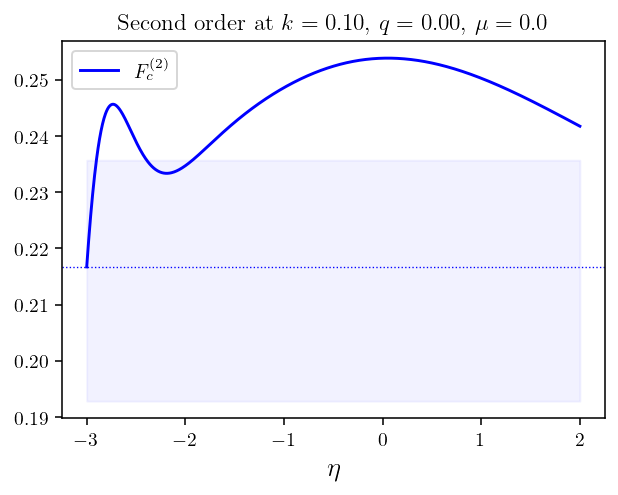

In [128]:
kp=0.1
qp=1.e-3
mup=0.0
kMq = np.sqrt(kp**2 + qp**2 - 2*kp*qp*mup)
cT12 = (kp*mup-qp)/kMq

sol=solve_second_order([qp,kMq,cT12], return_timedep=True)
Fc2_0=(5./7.+6/245*fx)*alphas(qp,kMq,cT12)+(2./7.-6/245*fx)*beta(qp,kMq,cT12)

# sol=solve_second_order([kp,qp,mup], return_timedep=True)
# Fc2_0=5./7.*alphas(kp,qp,mup)+2./7.*beta(kp,qp,mup)

plt.figure(figsize=(5,3.5), dpi=140)
plt.plot(fullt, sol[:,2], 'b', label=r'$F_c^{(2)}$')
plt.axhline(Fc2_0, color='b', linestyle=':', linewidth=0.7)
# plt.axhline(F2(kp,qp,mup)+fx*DeltaF2q_Mq__midlim(kp,qp,mup)[0], color='m', linewidth=0.7)
plt.fill_between(fullt, F2(kp,qp,mup)*(1-fx),F2(kp,qp,mup)*(1+fx), alpha=0.05, color='b')

plt.legend()
plt.title(r'Second order at $k='+'%.2f'%kp+r'$, $q='+'%.2f'%qp+r'$, $\mu='+'%.1f'%mup+r'$')
plt.xlabel(r'$\eta$', fontsize=14)
# plt.savefig('/home/fverdian/class/soundspeed-scripts/figure/F2_kers_eta.pdf', bbox_inches='tight')
plt.show()

In [129]:
#--------
# 3rd order
#--------
def DeltaF3_ennio(k,q,mu):
    x2=(k/q)**2;mu2=mu*mu
    num=4*(mu2-1)*x2*(-49*mu2+(5*mu2+22)*x2 +22)
    den=945*(x2*x2+(2-4*mu2)*x2+1)
    return num/den

def G2F2combo(k1,k2,cT):
    return [(5./7+0*6/245*fx)*alphas(k1,k2,cT)+(2./7-0*6/245*fx)*beta(k1,k2,cT),(3./7-0*3*17/245*fx)*alphas(k1,k2,cT)+(4./7-0*3*32/245*fx)*beta(k1,k2,cT),0,0]

def solve_F3_for_k(triplet, return_timedep=False):
    k , q, mu = triplet
    
    ker2_k_mq_full=solve_second_order([k,q,-mu], return_timedep=True)
    ker2_k_q_full=solve_second_order([k,q,mu], return_timedep=True)

    def F3_system(w, t):

        Fc3,Gc3,Fx3,Gx3 = w
        g_c_k=g_c_int(t-2*np.log(k/kref));g_c_q=g_c_int(t-2*np.log(q/kref))
        g_k=g_an(t-2*np.log(k/kref));g_q=g_an(t-2*np.log(q/kref))
        hOg_k=hOg_an(t-2*np.log(k/kref));hOg_q=hOg_an(t-2*np.log(q/kref))

        idx_t_F3=np.abs(fullt - t).argmin()
        ker2_k_mq=ker2_k_mq_full[idx_t_F3]
        ker2_k_q=ker2_k_q_full[idx_t_F3]

        #F3_c and G3_c
        kMq = np.sqrt(k*k + q*q - 2*k*q*mu)
        cT=(k*mu-q)/kMq
        SF3=g_c_int(t-2*np.log(q/kref))*alpha(q,kMq,cT)*ker2_k_mq[0]+alpha(kMq,q,cT)*ker2_k_mq[1]
        SG3=g_c_int(t-2*np.log(q/kref))*beta(kMq,q,cT)*2*ker2_k_mq[1]
        kPq = np.sqrt(k*k + q*q + 2*k*q*mu)
        cT=-(k*mu+q)/kPq
        SF3+=g_c_int(t-2*np.log(q/kref))*alpha(q,kPq,cT)*ker2_k_q[0]+alpha(kPq,q,cT)*ker2_k_q[1]
        SG3+=g_c_int(t-2*np.log(q/kref))*beta(kPq,q,cT)*2*ker2_k_q[1]

        dFc3dt = -(g_c_k+2*g_c_q)*Fc3 + Gc3 + SF3/3
        dGc3dt = -(0.5+g_c_k+2*g_c_q)*Gc3 + 1.5*((1-fx)*Fc3+fx*Fx3*g_k*g_q*g_q) + SG3/3

        #F3_c and G3_c
        kMq = np.sqrt(k*k + q*q - 2*k*q*mu)
        cT=(k*mu-q)/kMq
        SF3x=hOg_q*alpha(q,kMq,cT)*ker2_k_mq[2]+alpha(kMq,q,cT)*ker2_k_mq[3]
        SG3x=hOg_q*beta(kMq,q,cT)*2*ker2_k_mq[3]
        kPq = np.sqrt(k*k + q*q + 2*k*q*mu)
        cT=-(k*mu+q)/kPq
        SF3x+=hOg_q*alpha(q,kPq,cT)*ker2_k_q[2]+alpha(kPq,q,cT)*ker2_k_q[3]
        SG3x+=hOg_q*beta(kPq,q,cT)*2*ker2_k_q[3]

        dFx3dt = -(hOg_k+2*hOg_q)*Fx3 + Gx3 + SF3x/3
        dGx3dt = -(0.5+hOg_k+2*hOg_q)*Gx3 + 1.5*((1-fx)*Fc3/g_k/g_q/g_q+(fx-(k**2)/(kref**2)*np.exp(-t))*Fx3) + SG3x/3 -(k**2)/(kref**2)*np.exp(-t-supprshift)*dFx3dt
        return [dFc3dt, dGc3dt,dFx3dt, dGx3dt]
    
    tsol=np.linspace(np.log(k/kref)-10,np.log(k/kref)+18,100)
    tsol=fullt
    sol = odeint(F3_system, [F3(k,q,mu)-1/7*fx*DeltaF3_ennio(k,q,mu),F3(k,q,mu),F3(k,q,mu),F3(k,q,mu)], tsol, rtol=1.e-6, atol=1.e-7)
    if return_timedep:
        return [tsol,sol[:,0],sol[:,2]]
    return sol[idx_eta,0]

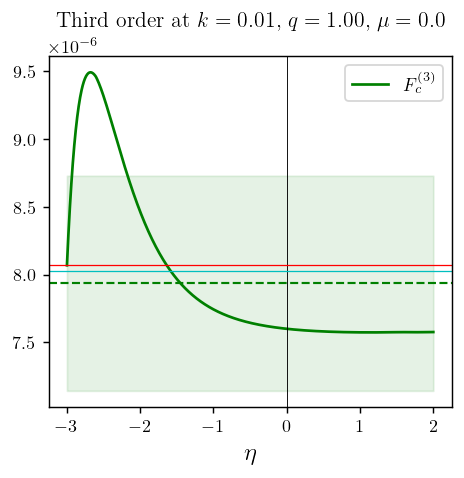

In [130]:
kp=0.01
qp=1
mup=0.

def DeltaF3_limitB(k,q,mu):
    # This is F3(k1=k,k2=q, k3=-q) eh
    x2=(k/q)**2;mu2=mu*mu;x=k/q
    return -(348*mu2*mu2-1187*mu2+363)/5670*x2

solF3=solve_F3_for_k([kp,qp,mup], return_timedep=True)

plt.figure(figsize=(4,3.5), dpi=130)
plt.plot( solF3[0],solF3[1], 'g', label=r'$F_c^{(3)}$')
plt.axhline(F3(kp,qp,mup), color='g', linewidth=1.2, linestyle='--')
plt.axvline(teval, color='k', linewidth=0.5)
plt.axhline(F3(kp,qp,mup)-1/7*fx*DeltaF3_ennio(kp,qp,mup), color='r', linewidth=0.7)
plt.fill_between(solF3[0], F3(kp,qp,mup)*(1-fx),F3(kp,qp,mup)*(1+fx), alpha=0.1, color='green')
plt.axhline(F3(kp,qp,mup)-1/7*fx*DeltaF3_limitB(kp,qp,mup), color='c', linewidth=0.7)

plt.legend()
plt.title(r'Third order at $k='+'%.2f'%kp+r'$, $q='+'%.2f'%qp+r'$, $\mu='+'%.1f'%mup+r'$')
plt.xlabel(r'$\eta$', fontsize=14)
# plt.savefig('/home/fverdian/class/soundspeed-scripts/figure/F2_kers_eta.pdf', bbox_inches='tight')
plt.show()

In [74]:
qlist=np.logspace(2,2.1,10)
Flist=[];Flist_EdS=[]
mup=1.
kp=0.1
for qp in qlist:
    print(f'q={qp:.1e}', end='\r')
    kMq = np.sqrt(kp**2 + qp**2 - 2*kp*qp*mup)
    cT12 = (kp*mup-qp)/kMq
    solF3=solve_F3_for_k([kp,qp,mup])
    Flist.append(solF3)
    Flist_EdS.append(F3(kp,qp,mup))
Flist=np.array(Flist);Flist_EdS=np.array(Flist_EdS);


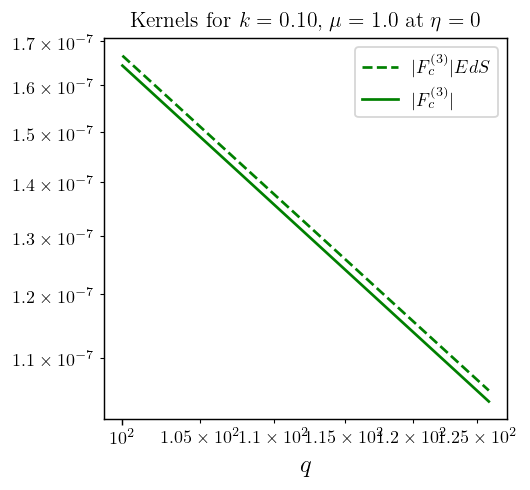

In [75]:
plt.figure(figsize=(4,3.8), dpi=130)
plt.plot(qlist, np.abs(Flist_EdS), 'g--', label=r'$|F_c^{(3)}| EdS$')
plt.plot(qlist, np.abs(Flist), 'g', label=r'$|F_c^{(3)}|$')

plt.legend()
plt.title(r'Kernels for $k='+'%.2f'%kp+r'$, $\mu='+'%.1f'%mup+r'$ at $\eta=0$')
# plt.ylabel(r'$F/F_\mathrm{EdS}-1$', fontsize=14)
plt.xlabel(r'$q$', fontsize=14)
plt.xscale('log')
plt.yscale('log')
# plt.savefig('/home/fverdian/class/soundspeed-scripts/figure/F3_limitB_ofq.pdf', bbox_inches='tight')
plt.show()

----
Limit D

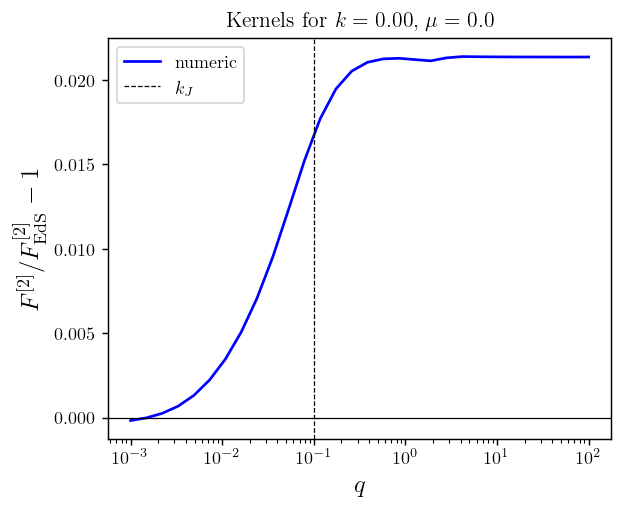

In [76]:
qlist=np.logspace(-3,2,30)
Flist=[]
mup=0 #MUST EVALUATE IT AT mu=0, otherwise the eds has a divergence
kp=0.001

def DeltaF2_limitD(mu):
    Eds=(4*mu*mu+3)/14
    delta=-18/245*(mu*mu+23/12)
    return Eds, delta

for qp in qlist:
    print(f'q={qp:.1e}', end='\r')
    kMq = np.sqrt(kp**2 + qp**2 - 2*kp*qp*mup)
    cT12 = (kp*mup-qp)/kMq
    solF2=solve_second_order([qp,kMq,cT12])[0]
    Flist.append([solF2,F2(kp,qp,mup)])

Flist=np.array(Flist)
plt.figure(figsize=(5,4), dpi=130)
plt.plot(qlist, Flist[:,0]/Flist[:,1]-1, 'b', label=r'numeric')

# plt.plot(qlist,(DeltaF2_limitD(mup)[0]+fx*DeltaF2_limitD(mup)[1])/Flist[:,1]-1, 'm:',label=r'analytic limit')

plt.axvline(0.1, color='k',linestyle='--', linewidth=0.7, label=r'$k_J$')
plt.axhline(0., color='k', linewidth=0.7)

plt.legend()
plt.title(r'Kernels for $k='+'%.2f'%kp+r'$, $\mu='+'%.1f'%mup+r'$')
plt.ylabel(r'$F^{[2]}/F^{[2]}_\mathrm{EdS}-1$', fontsize=14)
plt.xlabel(r'$q$', fontsize=14)
plt.xscale('log')
# plt.savefig('/home/fverdian/class/soundspeed-scripts/figure/F2_limitD_ofq.pdf', bbox_inches='tight')
plt.show()

In [17]:
print(Flist[:,0])

# np.savetxt('/home/fverdian/class/soundspeed-scripts/kernels-fullnum/Slurm-output/F2reldiff.txt', np.column_stack((qlist, Flist[:,0]/Flist[:,1]-1)),header='q, relative differenceto EdS for kref=0.1, at k=0.1')

[2.03245612e-01 2.03330895e-01 2.03449257e-01 2.03615360e-01
 2.03823691e-01 2.04060793e-01 2.04260846e-01 2.04281624e-01
 2.03810787e-01 2.02234290e-01 1.98473420e-01 1.90788460e-01
 1.76879379e-01 1.54779192e-01 1.24823676e-01 9.12425757e-02
 6.04559526e-02 3.69203576e-02 2.12795965e-02 1.18243367e-02
 6.43099180e-03 3.45581325e-03 1.84489694e-03 9.81414203e-04
 5.21076100e-04 2.76375335e-04 1.46501725e-04 7.76315754e-05
 4.11207622e-05 2.17804725e-05]


----
UV limit for F3 when varying k

In [22]:
klist=np.logspace(-4,2,30)
Flist=[];Flist_EdS=[]
mup=1.
qp=10
for kp in klist:
    print(f'k={kp:.1e}', end='\r')
    solF3=solve_F3_for_k([kp,qp,mup])
    Flist.append(solF3)
    Flist_EdS.append(F3(kp,qp,mup))
Flist=np.array(Flist);Flist_EdS=np.array(Flist_EdS);


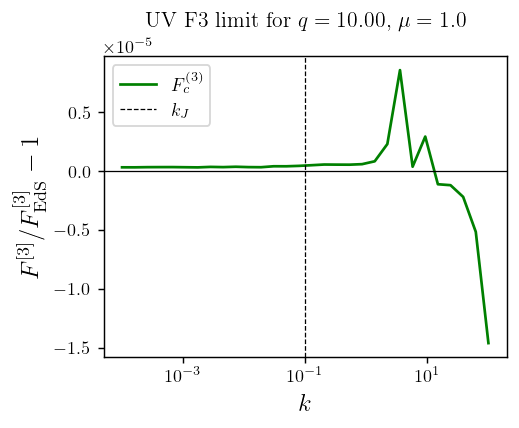

In [23]:
plt.figure(figsize=(4,3), dpi=130)


# plt.plot(klist, Flist/Flist_EdS-1, 'g', label=r'$F_c^{(3)}$')
plt.plot(klist, Flist-Flist_EdS, 'g', label=r'$F_c^{(3)}$')

plt.axhline(0., color='k', linewidth=0.7)

plt.axvline(0.1, color='k',linestyle='--', linewidth=0.7, label=r'$k_J$')

plt.legend()
plt.title(r'UV F3 limit for $q='+'%.2f'%qp+r'$, $\mu='+'%.1f'%mup+r'$')
plt.ylabel(r'$F^{[3]}/F^{[3]}_\mathrm{EdS}-1$', fontsize=14)
plt.xlabel(r'$k$', fontsize=14)
plt.xscale('log')
# plt.savefig('/home/fverdian/class/soundspeed-scripts/figure/F3_UVlimit_ofk.pdf', bbox_inches='tight')
plt.show()